In [81]:
import sys, os

import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.inspection import permutation_importance

## Loading Dataset

In [27]:
df = pd.read_csv("../../data/processed/signalEUR_USD_Labelled_v1_processed.csv", index_col=0)

In [28]:
df["Date"] = pd.to_datetime(df["Date"])

# Labels 3 days ahead
df["label_3days"] = df["label"].shift(-3)

# Labels 5 days ahead
df["label_5days"] = df["label"].shift(-5)

In [29]:
# Drop NA
df = df.dropna(axis = 0)
df = df.reset_index(drop=True)
df.head()

,Date,Price,Open,High,Low,Change %,diff_1,label,sma,ema,...,macd,macd_s,macd_h,roc,rsi,Bollinger_up,Bollinger_down,cci,label_3days,label_5days
0,2013-02-15,1.3363,1.3363,1.3394,1.3306,0.01%,0.0002,0.0,1.344735,1.336730,...,0.002701,0.005461,-0.002760,-0.000150,39.939646,1.364281,1.325189,-62.849696,1.0,0.0
1,2013-02-18,1.3352,1.3357,1.3377,1.3321,-0.08%,-0.0011,0.0,1.344925,1.335553,...,0.001906,0.004750,-0.002844,-0.004102,38.588551,1.363994,1.325856,-68.561252,1.0,1.0
2,2013-02-19,1.3388,1.3352,1.3397,1.3329,0.27%,0.0036,2.0,1.345260,1.338051,...,0.001549,0.004109,-0.002561,-0.004906,45.544851,1.363601,1.326919,-57.039491,0.0,0.0
3,2013-02-20,1.3281,1.3387,1.3434,1.3270,-0.80%,-0.0107,1.0,1.345075,1.330396,...,0.000398,0.003367,-0.002969,-0.012785,32.802173,1.364052,1.326098,-90.131403,1.0,2.0
4,2013-02-21,1.3189,1.3283,1.3291,1.3161,-0.69%,-0.0092,1.0,1.344140,1.321553,...,-0.001242,0.002445,-0.003688,-0.012873,25.675429,1.366251,1.322029,-149.263447,0.0,1.0


## Window

In [42]:
time = ["Date"]

columns = ["Price",  "sma", "ema", "cma", "macd",	"macd_s",
"macd_h", "roc", "rsi",	"Bollinger_up", "Bollinger_down", "cci"]

labels = ["label", "label_3days", "label_5days"]

features = df[time + columns + labels]

features.shape

(2311, 16)

In [43]:
features.head()

,Date,Price,sma,ema,cma,macd,macd_s,macd_h,roc,rsi,Bollinger_up,Bollinger_down,cci,label,label_3days,label_5days
0,2013-02-15,1.3363,1.344735,1.336730,1.335315,0.002701,0.005461,-0.002760,-0.000150,39.939646,1.364281,1.325189,-62.849696,0.0,1.0,0.0
1,2013-02-18,1.3352,1.344925,1.335553,1.335311,0.001906,0.004750,-0.002844,-0.004102,38.588551,1.363994,1.325856,-68.561252,0.0,1.0,1.0
2,2013-02-19,1.3388,1.345260,1.338051,1.335408,0.001549,0.004109,-0.002561,-0.004906,45.544851,1.363601,1.326919,-57.039491,2.0,0.0,0.0
3,2013-02-20,1.3281,1.345075,1.330396,1.335211,0.000398,0.003367,-0.002969,-0.012785,32.802173,1.364052,1.326098,-90.131403,1.0,1.0,2.0
4,2013-02-21,1.3189,1.344140,1.321553,1.334782,-0.001242,0.002445,-0.003688,-0.012873,25.675429,1.366251,1.322029,-149.263447,1.0,0.0,1.0


## Train test split

In [54]:
X = features.drop(labels = time + labels, axis=1 )
y = features[["label"]]

print(X.shape)
print(y.shape)

(2311, 12)
(2311, 1)


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1848, 12) (463, 12)
(1848, 1) (463, 1)


## Training Decision Tree

In [65]:
tree_model1 = DecisionTreeClassifier(random_state=42)

tree_model1.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [66]:
tree_model1.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [102]:
tree_model1_accuracy = tree_model1.score(X_test, y_test)

print(f"Accuracy: {tree_model1_accuracy:.5f}")

Accuracy: 0.49892


In [63]:
tree_model1.feature_importances_

array([0.01748894, 0.01940848, 0.04385903, 0.08316514, 0.08889271,
       0.04522756, 0.10581504, 0.12204474, 0.23980838, 0.02851884,
       0.03304013, 0.17273102])

In [69]:
feature_impotance = permutation_importance(tree_model1, X_train, y_train)

In [78]:
feature_impt_results = pd.DataFrame({"Feature": X_train.columns, "Importances_mean": feature_impotance["importances_mean"],
"Importances_std": feature_impotance["importances_std"]})

# Sort in descending order
feature_impt_results = feature_impt_results.sort_values(by="Importances_mean", ascending=False, ignore_index=True)

feature_impt_results

,Feature,Importances_mean,Importances_std
0,rsi,0.641126,0.003563
1,cci,0.448268,0.007695
2,roc,0.238636,0.003780
3,macd_h,0.223485,0.008725
4,macd,0.193831,0.007993
5,cma,0.129978,0.002746
6,macd_s,0.068615,0.004833
7,Bollinger_down,0.066775,0.002099
8,ema,0.050866,0.003042
9,Bollinger_up,0.040584,0.003371


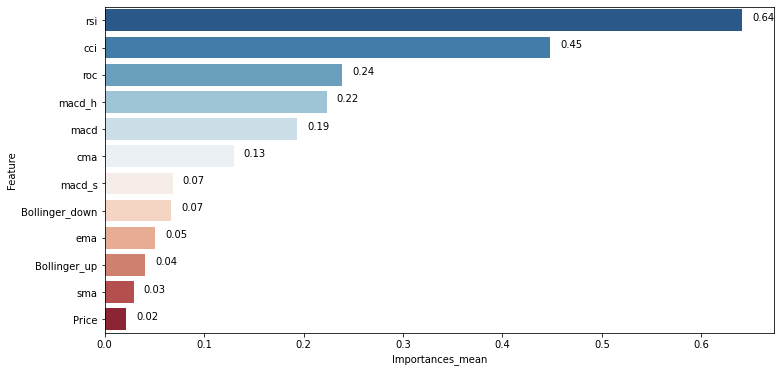

In [99]:
fig, ax = plt.subplots(figsize = (12, 6))
ax = sns.barplot(x="Importances_mean", y ="Feature", data=feature_impt_results, palette="RdBu_r")

# for i in ax.containers:
#     ax.bar_label(i)

for p in ax.patches:
    _x = p.get_x() + p.get_width() + float(0.01)
    _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
    value = '{:.2f}'.format(p.get_width())
    ax.text(_x, _y, value, ha="left")

plt.show()